#Project: Real Estate Analysis
#Authors: Desmond , Jair  , Alexander, Jason
#Date

#This project aims to invesitgate the relationship between real esate metrics and weather data

In [66]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as pyplot
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.types import Integer, Text, String, DateTime, Float


In [67]:
#Method 1
#from models import Base, RealEEstateData

#Method 2
#from database_real_estate import SessionRealEstate, RealEstateData
#from database_weather  import SessionWeather, WeatherData

In [68]:
#Data Loading and SQL Operations:
#Method 1
engine = create_engine('sqlite:///Resources/Housing_Data_Model.sqlite')
Session = sessionmaker(bind=engine)
session = Session()


queried_data = pd.DataFrame(engine.execute("SELECT * FROM housing_data").fetchall())



#Method 2
#real_estate_session = SessionRealEstate()
#weather_session = SessionWeather()

#real_estate_df = pd.read_sql(real_estate_session.query(RealEstateData).statment,real_estate_session.bind)
#weather_df = pd.read_sql(weather_session.query(WeatherData).statment, weather_session.bind)

In [69]:
#Close Sesisons
print(queried_data)
session.close()


           ID  bed  bath  acre_lot          state  zip_code  house_size  \
0       24268  3.0   2.0      0.16  Massachusetts      1002      1280.0   
1       25013  4.0   3.0      0.46  Massachusetts      1075      2108.0   
2       25062  4.0   1.0      0.91  Massachusetts      1027      1404.0   
3       25101  3.0   2.0      0.16  Massachusetts      1002      1280.0   
4       25181  4.0   2.0      0.13  Massachusetts      1040      1529.0   
...       ...  ...   ...       ...            ...       ...         ...   
15674  904732  3.0   2.0      0.06       New York     10473      1950.0   
15675  904762  6.0   4.0      0.10       New York     11550      2041.0   
15676  904772  3.0   2.0      0.04       New York     10461      1852.0   
15677  904853  3.0   3.0      0.31       New York     10502      1905.0   
15678  904885  1.0   2.0      9.00       New York     10543      1098.0   

                   prev_sold_date     price  price_per_sqfoot    month  
0      2021-08-19 00:00:00

In [70]:
#Load real esate and weather data from CSV 
#real_estate_data = pd.read_csv('resources/clean_real_estate_data.csv')

#weather_data = pd.read_csv('resources/real/real_estate_data.csv')

In [71]:
queried_data.corr(numeric_only=True)

#Evaluate Data
#Drop price per-sqft


,ID,bed,bath,acre_lot,zip_code,house_size,price,price_per_sqfoot
ID,1.000000,0.078941,0.146057,0.025994,0.659092,0.052058,0.099181,0.114986
bed,0.078941,1.000000,0.648341,-0.014197,0.019322,0.479547,0.280352,-0.018215
bath,0.146057,0.648341,1.000000,0.011911,0.055871,0.524287,0.567940,0.211843
acre_lot,0.025994,-0.014197,0.011911,1.000000,0.007317,0.007353,0.001235,-0.009537
zip_code,0.659092,0.019322,0.055871,0.007317,1.000000,-0.031749,0.005399,0.006650
house_size,0.052058,0.479547,0.524287,0.007353,-0.031749,1.000000,0.349971,-0.031920
price,0.099181,0.280352,0.567940,0.001235,0.005399,0.349971,1.000000,0.684290
price_per_sqfoot,0.114986,-0.018215,0.211843,-0.009537,0.006650,-0.031920,0.684290,1.000000


In [72]:
#| Variable           | Strong Positive Correlations                 | Strong Negative Correlations                 |
#|--------------------|----------------------------------------------|----------------------------------------------|
#| Unnamed: 0         | Zip Code (0.659092)                          | -                                            |
#| Bed                | Bath (0.648341), House Size (0.479547)       | -                                            |
#| Bath               | Bed (0.648341), House Size (0.524287)        | -                                            |
#| Acre Lot           | -                                            | -                                            |
#| Zip Code           | Unnamed: 0 (0.659092)                        | House Size (-0.031749)                       |
#| House Size         | Bed (0.479547), Bath (0.524287)              | Zip Code (-0.031749)                         |
#| Price              | Bath (0.567940), House Size (0.349971), Price Per Sqfoot (0.684290) | -                     |
#| Price Per Sqfoot   | Price (0.684290)                             | -                                            |


In [73]:
#Merge dataset based on common feature
#merged_data = pd.merge(real_estate_data, weather_df, on = 'location') #getdummy on location to encode text to numerical
#merged_data = pd.get_dummies(merged_data,columns=['location'], drop_first= True)

In [74]:
#Remove Outliers
Q1 = queried_data['price'].quantile(.25)
Q3 = queried_data['price'].quantile(.75)
IQR = Q3 -Q1
queried_data = queried_data[(queried_data['price'] > Q1- 1.5 * IQR)& (queried_data['price'] < Q3 + 1.5 *  IQR)]

In [75]:
X = queried_data.loc[:,['house_size', 'zip_code', 'acre_lot','bed']] #Features #find zipcode insted from top 5 States
Y = queried_data['price'] #Target variable

In [76]:
#Split Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2,random_state =42)

In [77]:
#Standardize features
scaler = StandardScaler()  #
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
#Principal Component Analysis (PCA)
pca = PCA(n_components =2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [79]:
#K-Means Clustering
kmeans = KMeans(n_clusters = 3, random_state =  42) #Why three clusters
X_train_cluster = kmeans.fit_predict(X_train_scaled)
X_test_cluster = kmeans.predict(X_test_scaled)

c:\Users\desmo\anaconda3\envs\EdX\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [80]:
#Intialize Paramter Grid
param_grid = {
    'n_estimators':[50,100,200],
    'max_depth' : [None,10,20],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

In [86]:
#Regression Models
models = {
    'Linear Regression': LinearRegression(),#Linear Regression Perform Poorest
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42), #Measures feature importance #How many trees? #Process of improvement using <-
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state =42)
}

mse_results = []

#Cross Validate Scores
for model_name, model in models.items():
   # Cross- validation
   cv_results = cross_val_score(model, X_train_scaled,y_train,cv=5,scoring='r2')# use rsquared value
   cv_mse = -cv_results.mean()
   mse_results.append((model_name,cv_mse))
   print(f'{model_name}- Cross-Validated R Squared Error:{cv_mse}')

best_model = min(mse_results, key =lambda x: x[1])
print(f'Best Model:{best_model}')

Linear Regression- Cross-Validated R Squared Error:-0.09838708376026908
Decision Tree Regressor- Cross-Validated R Squared Error:-0.9543269180905426
Random Forest Regressor- Cross-Validated R Squared Error:-0.9650023979091239
Gradient Boosting Regressor- Cross-Validated R Squared Error:-0.706194625056925
Best Model:('Random Forest Regressor', -0.9650023979091239)


In [82]:
#Find Best Parameters
rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf_model,param_grid =param_grid, cv=5,scoring='neg_mean_squared_error', n_jobs =-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hpyerparameters",best_params)


Best Hpyerparameters {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


      Feature  Importances
0  house_size     0.424606
1    zip_code     0.410131
2    acre_lot     0.123997
3         bed     0.041266


AttributeError: Text.set() got an unexpected keyword argument 'roation'

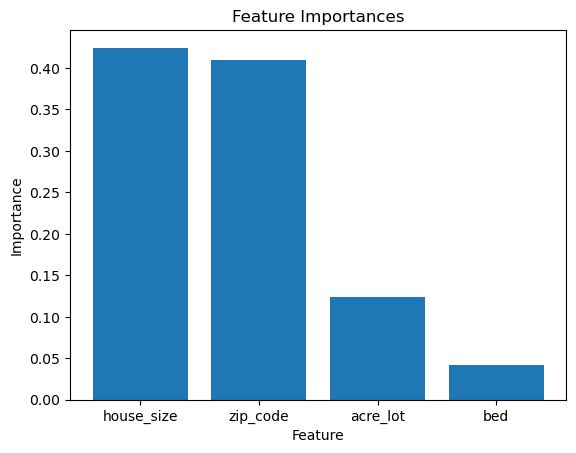

In [84]:
#Train Model Using Best Paramters
best_rf_model = RandomForestRegressor(random_state=42,**best_params)
best_rf_model.fit(X_train_scaled,y_train)


#Get Feature Importances
feature_importances = best_rf_model.feature_importances_

#Create Dataframe to display Feature Importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importances': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importances',ascending=False)

#Print Feature Importances
print(feature_importance_df)
plt.bar(feature_importance_df['Feature'],feature_importance_df['Importances'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(roation= 45)
plt.show()




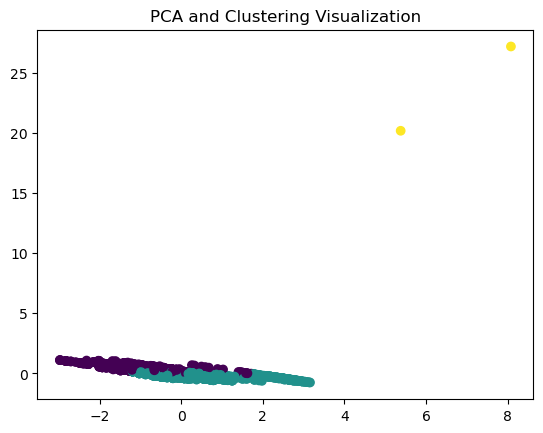

In [65]:
#Visualization 
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=X_test_cluster,cmap="viridis")
plt.title('PCA and Clustering Visualization')
plt.show()


In [ ]:
#Q/A 
#Things to Do:
#Explain bias and limitations

